# 01 Image Classification with fastai

remember to set runtime type to GPU

## 1. The fastai Philosophy

In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

- [fastai](https://www.fast.ai/) is a software package and course created by Jeremy Howard, Rachel Thomas, and Sylvain Gugger. 
- A good way to think about fastai is as a high level PyTorch wrapper library. If you're familiar with keras, **tensorflow is to keras and pytorch is (roughly) to fastai.**
- Unlike keras, fastai is **very opinionated** library. 
- Instead of creating a generic tools for deep learning experts to use, the fastai founders are creating courses and a library that make it **dramatically easier and faster** to get cutting-edge results quickly with deep learning. 
- One tool they use to accomplish this is by **encoding best practices from research directly into the library**. 
- This approach has led to some pretty dramatic results, including [training a model on imagenet in 18 minutes](https://www.fast.ai/2018/08/10/fastai-diu-imagenet/) and some breakthrough results in [pretraining models for natural language processing](https://arxiv.org/pdf/1801.06146.pdf). 
- Now, there are some trade-offs. In my experience, fastai can be buggy, difficult to debug, and challenging to generalize in some cases. 
- My thinking on these trade-offs, in 2020, is this: 


1. For quickly exploring + testing top-performing models and new ideas on your own datasets, **it's hard to beat fastai**. In my experience, you'll be able to test lots of ideas quickly, and move fast. 
2. Having a reasonable good understanding of the underlying PyTorch code can make you much more effective with fastai, allowing you to "pick and choose" the parts of the fastai library you want to use, and what you want to implement yourself in PyTorch. 
3. I still really like Keras and Tensorflow, but I rarely use these libraries as **starting points** on new projects. 

---

## 2. Let's Get Some Data

In [2]:
!pip install wget #For colab

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=c5e18a279620ab9da1d648c7265cbc761b092cd9a0dd73d6b1863cd17e0db809
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [3]:
import wget, argparse, zipfile, tarfile, sys
from pathlib import Path

def simple_progress_bar(current, total, width=80):
    progress_message = "Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total)
    sys.stdout.write("\r" + progress_message); sys.stdout.flush()

def get_and_unpack(url, location='data/'):
    Path(location).mkdir(exist_ok=True)
    filename = wget.download(url, out=location, bar=simple_progress_bar)
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall(path=location)
    zip_ref.close()

In [4]:
get_and_unpack(url='http://www.welchlabs.io/unccv/deep_learning/bbc_train.zip')

Downloading: 100% [90591239 / 90591239] bytes

**Optional in Workshop - let's code this part together from scratch in an empty notebook.**

In [5]:
%pylab inline
from fastai.vision import *
from pathlib import Path
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [6]:
path=Path('data/bbc_train')

In [7]:
path.ls()

[PosixPath('data/bbc_train/bboxes.json'),
 PosixPath('data/bbc_train/classification_labels.csv'),
 PosixPath('data/bbc_train/.DS_Store'),
 PosixPath('data/bbc_train/masks'),
 PosixPath('data/bbc_train/images')]

- The BBC-1k dataset includes labels for classification, bounding box detection, and semantic segmentation. 
- Let's load the classification labels:

In [8]:
labels=pd.read_csv(path/'classification_labels.csv')

In [9]:
labels.head()

,filename,label,label_index
0,P2050936.jpg,ball,2
1,P2050922.jpg,ball,2
2,P2060163.jpg,brick,1
3,P2060003.jpg,ball,2
4,P2060017.jpg,ball,2


- fastai provides lots of methods for creating data iterators, called `DataBunches` in the fastai nomenclature
- `DataBunches` allow us to quickly create pipelines for loading data into randomized minibatches

## 3. Setup fastai ImageDataBunch

In [15]:
data=ImageDataBunch.from_df(path=path/'images',
                            df=labels,
                            valid_pct=0.2, #% of data used for validation set
                            fn_col='filename',
                            label_col='label', 
                            ds_tfms=get_transforms(),
                            size=256,
                            bs=64 #batch size
                            ).normalize(imagenet_stats) # pixel values normalized using imagenet statistics

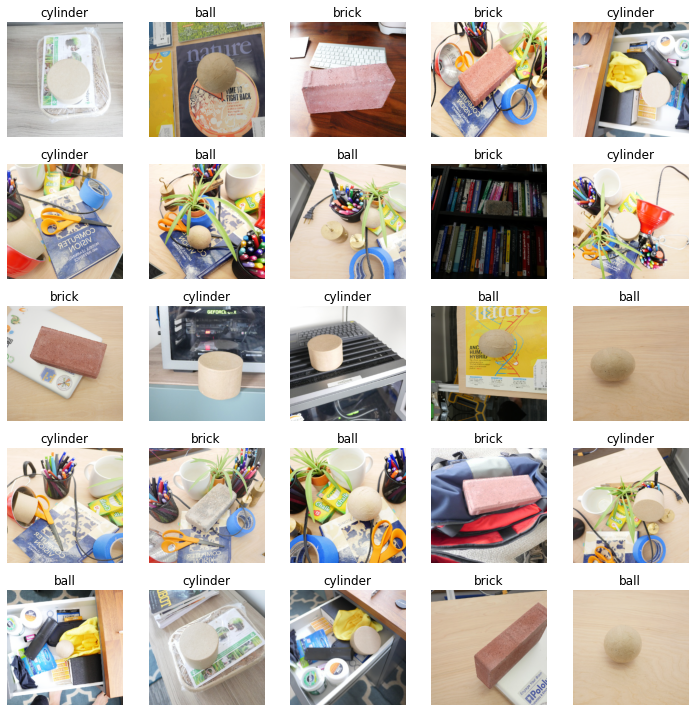

In [12]:
data.show_batch(figsize=(10,10))

- Creating a model is as simple as picking an architecture, passing in our `ImageDataBunch`, and choosing a performance metric!

## 4. Create Learner, Find Learning Rate

In [16]:
learn=cnn_learner(data,
                  models.resnet34,
                  metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


- By defualt, fastai downloads the weights for a pretrained model. 
- Usually when solving new problems, it's best to start with a pretrained model, and just train the last few layers on the new task. 
- We can do this by freezing the "model backbone": 

In [17]:
learn.freeze()

- Choosing a learning rate can be difficult. 
- fastai provides a great tool for selecting an effective learning rate, `learn.lr_find()`.
- `lr_find` takes steps using various learning rates, and measure the change in our loss function. 
- By plotting the loss as a function of learning rate, we can select an ideal learning rate. 
- Ideally, we want to pick a learning that maximizes the slope of our loss vs learning rate curve. 

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


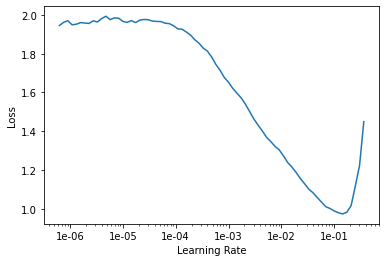

In [19]:
learn.recorder.plot()

- Fastai has a couple of other terrific built in features, **cylical learning rates**, and **differential learning rates**. 
- We're using each of these here, and will cover them in more detail later. 

## 5. Train Model

In [20]:
lr=5e-3
learn.fit_one_cycle(4,#epochs
                    slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.190472,0.328140,0.872340,00:19
1,0.762224,0.188124,0.946809,00:17
2,0.561076,0.127891,0.978723,00:17
3,0.427408,0.090019,0.962766,00:17


- We can further improve performance by training the whole model, not just our last few layers. 

In [21]:
learn.unfreeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


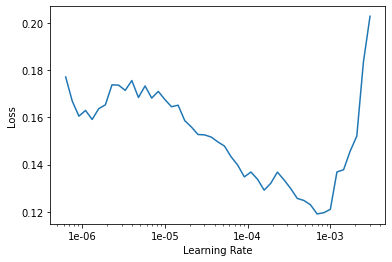

In [23]:
learn.recorder.plot()

In [24]:
lr=5e-5
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.198796,0.076824,0.962766,00:18
1,0.161642,0.052375,0.978723,00:18
2,0.141902,0.033836,0.989362,00:18
3,0.130502,0.026305,0.994681,00:18
4,0.108896,0.022325,0.994681,00:18
5,0.096524,0.021649,0.989362,00:18
6,0.082866,0.020007,0.989362,00:18
7,0.072558,0.021386,1.000000,00:18


## 6. Visualize Results

- fastai also has some really nice visualization & interpretation methods:

In [25]:
interp=ClassificationInterpretation.from_learner(learn)

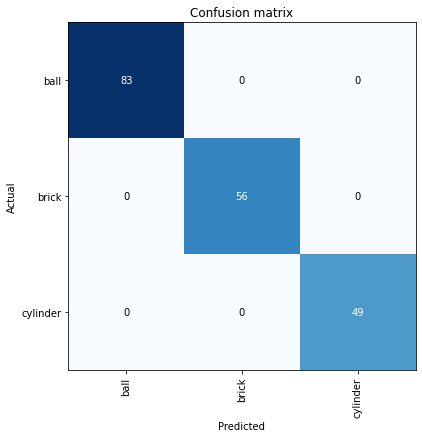

In [26]:
interp.plot_confusion_matrix(figsize=(6,6))

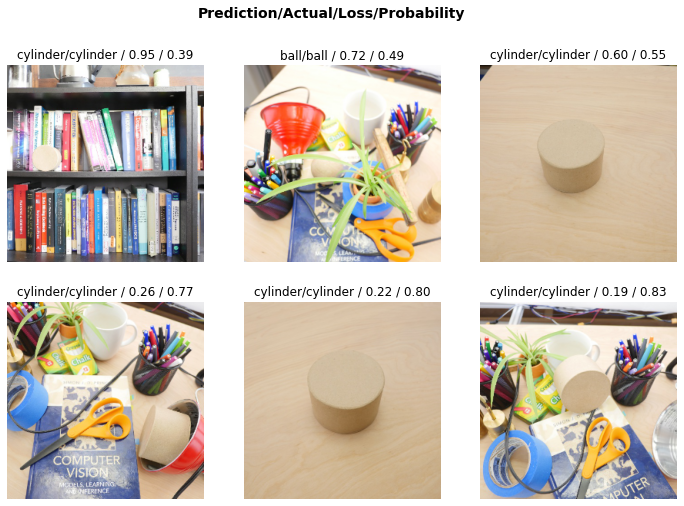

In [27]:
interp.plot_top_losses(k=6, figsize=(12, 8))

## 7. Save Model Weights

In [28]:
learn.export('/home/bbc-classifier.pkl') #Save Weights Locally

- If running from google colab, you can download the model weights by clicking the file icon on the left.
- You can also save directly to your google drive - cool right?!
- This will come in handy for model deploymnet later
- You may need to create a folder called "dsgo" in you google drive for the export link below to work
- Also, note that to automatically download your model file, you may need to create a share-able link in google drive, and change the file permissions to allow anyone with the link to view.

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
learn.export('/content/gdrive/My Drive/Colab Notebooks/dsgo/bbc-classifier.pkl')